In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
#from scipy import special
import scipy.optimize as so
from sympy import *


In [2]:
from functions import *

## CREATION OF OBSERVATION FILES 

i am inventig an array of observations, représenting measurements of temperature in the soil at 5 cm and 10 cm depth. Then i used something to sample it at the wanted frequency, for the data assimilation part i will try to observe which frequency of observation gives enough information to correct the model and give an appropriate solution. 

In [3]:
 #paramètres 
limt=82*1
dt=1/60
tt=np.arange(0,limt,dt)
freq=60  # minutes 

limx=100
dx=1
xx=np.arange(0,limx,dx)

s=5  #standard dev   gaussian
mu=0   #moyenne gaussienne 
K=0.6  #thermal conductivity of soil

In [4]:
#measurements, truth of temperature and time of the measurements 
mes_5cm, true_5cm, tt_obs_5cm= obs_5(dt,limt,freq)

mes_10cm, true_10cm, tt_obs_10cm= obs_10(dt,limt,freq)

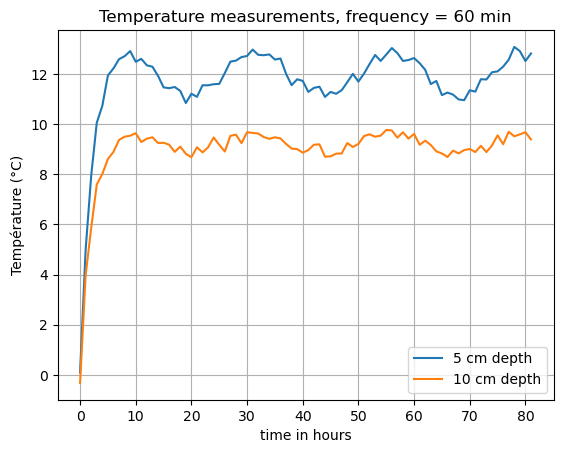

In [5]:
plt.plot(tt_obs_5cm, mes_5cm,label='5 cm depth')
plt.plot(tt_obs_10cm, mes_10cm,label='10 cm depth')

plt.title('Temperature measurements, frequency = '+ str(freq)+' min')
plt.xlabel('time in hours')
plt.ylabel('Température (°C)')
plt.legend()
plt.grid()

## DATA ASSIMILATION - 3D VAR


In [55]:
### parameters for 3DVAR

## Type and timing of observations

nvarobs = [5,10]            ## observed variables   mesure à 10,  et 5 cm 
nobs = len(nvarobs)
assim_steps =tt_obs_10cm   # range(0,50,5)  #fréquence d'assimilation 1 fois par heure 
#print(assim_steps)
nassim = len(assim_steps)
#assim_windows = 50   # 50
#_______________________________________________
## Observation operator
hobs = np.zeros((nobs,len(xx)))
j=0
for i in range(nobs):
    hobs[j,nvarobs[i]] = 1 #binaire 1 avec obs 0 aucune obs
    j += 1
print(np.shape(hobs))
#_____________________________________________________________


#observations: mesure de température 
yobs=np.vstack((mes_5cm,mes_10cm))
#observation covariance matrix
Robs=0.5**2

#________________________________________
#less and less precise the deeper it is 
#Pmat
Pmat=np.linspace(0.5,0.01,len(xx))   #juste les termes diagonaux 
#B = np.eye(3)/(xstd**2)



#euler forward scheme gives prevision of temperature in depth for the next time step using state vector x
def euler_f_assim(x):
    #x état du    #it moment ou on commence la simulation numéro de pas de temps        
    Tf=x
    Tz=np.zeros(len(x))
    for j in range(1,len(xx)-1):
        Tz[j]=Tf[j]+(K*dt/(dx**2))*(Tf[j+1]+Tf[j-1]-2*Tf[j])
       
    return Tz

(2, 100)


In [56]:
Nt=len(tt)
Nx=len(xx)

#_________________________________

xb_save = np.zeros((Nt+1,Nx))   # stocke résultats du modèle d'origine 
xa_save = np.zeros((Nt+1,Nx))   #stocke résultats du modèle avec assimilation de données 
xb_save[0,:] = gauss(xx, mu, s) # valeur au pas de temps 0   #backgroud
Var_save = np.zeros((Nt+1,Nx))  #valeur de la variance 
Var_save[0,:] = Pmat

for it in range(NT):
   # t=tt[i]#moment dans la simulation
    
#FORECAST
    xb=xb_save[it,:]#champ de température au temps t   background 
    xin=euler_f_assim(xb)# prévision à t+1 en faisant tourner le modèle 
#si H est changé à chaque pas de temps faire qqch 

    if tt[it] in tt_obs_10cm : #ANALYSE 
        iobs=0
        yo=yobs[:,iobs]
        xa = so.minimize(CostFunction(xin,xb,yo,Pmat,Robs,hobs),xb, args=(xin),  # minimize pour le paramètre xin 
                   method='Powell',
                   options={'maxiter': 30})
        #Pmat= nb
        iobs=+1
        xb_save[it+1,:] = xb
        xa_save[it+1,:] = xa
        #Var_save[:,it+1] = np.diag(Pmat)





TypeError: 'numpy.float64' object is not callable